In [1]:
import multiprocess as mp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
from tqdm import tqdm
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
import datetime
from sklearn.preprocessing import quantile_transform
pd.options.mode.chained_assignment = None  # default='warn'
import gc
import requests
from urllib.parse import urlparse

In [2]:
basedir = './prepped_data/'

In [3]:
%%time
main_data_df = pd.read_csv(basedir + 'main_data_ver_7.csv')
print(main_data_df.shape)
main_data_df.head()

(1175640, 20)
Wall time: 4.22 s


,지번주소,계약년월,계약일,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표
0,서울특별시 강남구 대치동 891-23,201302,8,"22,500",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06
1,서울특별시 강남구 대치동 891-23,201303,21,"23,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06
2,서울특별시 강남구 대치동 891-23,201305,2,"22,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06
3,서울특별시 강남구 대치동 891-23,201306,3,"22,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06
4,서울특별시 강남구 대치동 891-23,201306,11,"22,500",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06


In [7]:
main_data_df['년'] = main_data_df['계약년월'].apply(lambda x: int(str(x)[:4]))
main_data_df['월'] = main_data_df['계약년월'].apply(lambda x: int(str(x)[-2:]))

In [4]:
main_data_df['건축년도'].isna().sum()

20161

In [5]:
nan_df = main_data_df[main_data_df['건축년도'].isna()]
print(nan_df.shape)
nan_df.head()

(20161, 20)


,지번주소,계약년월,계약일,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표
2418,서울특별시 구로구 오류동 75-2,201401,20,"350,000",NaN,토지,618.0,대,일반상업지역,지정되지않음,상업기타,평지,부정형,세로한면(가),0,서울특별시 구로구 경인로20나길 63-0,구로구,오류동,941717.275212,1.944069e+06
35255,서울특별시 동대문구 이문동 255-182,201511,9,"188,000",NaN,토지,248.0,대,일반상업지역,제2종일반주거지역,상업용,평지,세로장방,중로한면,0,서울특별시 동대문구 이문로 156-0,동대문구,이문동,961350.710133,1.955761e+06
80183,서울특별시 구로구 고척동 76-11,201306,17,"170,000",NaN,토지,542.0,잡종지,준공업지역,지정되지않음,공업용,평지,사다리형,세로한면(불),0,서울특별시 구로구 중앙로 10-5,구로구,고척동,943879.907931,1.944652e+06
81063,서울특별시 동대문구 장안동 432-10,201307,12,"164,000",NaN,토지,304.4,대,일반상업지역,지정되지않음,주상용,평지,세로장방,소로한면,0,서울특별시 동대문구 천호대로83길 16-0,동대문구,장안동,961560.039662,1.951600e+06
85721,서울특별시 관악구 신림동 1433-136,201411,11,"77,000",NaN,토지,93.6,대,준주거지역,지정되지않음,단독,평지,자루형,세로한면(가),0,서울특별시 관악구 남부순환로 1585-7,관악구,신림동,949304.561300,1.942976e+06


In [6]:
toji_df = main_data_df[main_data_df['주택유형'] == '토지']
print(toji_df.shape)
toji_df.head()

(16692, 20)


,지번주소,계약년월,계약일,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표
2418,서울특별시 구로구 오류동 75-2,201401,20,"350,000",NaN,토지,618.0,대,일반상업지역,지정되지않음,상업기타,평지,부정형,세로한면(가),0,서울특별시 구로구 경인로20나길 63-0,구로구,오류동,941717.275212,1.944069e+06
35255,서울특별시 동대문구 이문동 255-182,201511,9,"188,000",NaN,토지,248.0,대,일반상업지역,제2종일반주거지역,상업용,평지,세로장방,중로한면,0,서울특별시 동대문구 이문로 156-0,동대문구,이문동,961350.710133,1.955761e+06
80183,서울특별시 구로구 고척동 76-11,201306,17,"170,000",NaN,토지,542.0,잡종지,준공업지역,지정되지않음,공업용,평지,사다리형,세로한면(불),0,서울특별시 구로구 중앙로 10-5,구로구,고척동,943879.907931,1.944652e+06
81063,서울특별시 동대문구 장안동 432-10,201307,12,"164,000",NaN,토지,304.4,대,일반상업지역,지정되지않음,주상용,평지,세로장방,소로한면,0,서울특별시 동대문구 천호대로83길 16-0,동대문구,장안동,961560.039662,1.951600e+06
85721,서울특별시 관악구 신림동 1433-136,201411,11,"77,000",NaN,토지,93.6,대,준주거지역,지정되지않음,단독,평지,자루형,세로한면(가),0,서울특별시 관악구 남부순환로 1585-7,관악구,신림동,949304.561300,1.942976e+06


In [8]:
main_data_df.loc[toji_df.index,'건축년도'] = main_data_df.loc[toji_df.index,'년']

In [9]:
nan_df = main_data_df[main_data_df['건축년도'].isna()]
print(nan_df.shape)
nan_df.head()

(3469, 22)


,지번주소,계약년월,계약일,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표,년,월
93314,서울특별시 영등포구 영등포동4가 117-7,201507,25,"229,000",NaN,제2종근린생활,303.1,대,준주거지역,지정되지않음,상업용,평지,사다리형,세로한면(가),1,서울특별시 영등포구 영신로30길 11-0,영등포구,영등포동4가,947197.960915,1.946779e+06,2015,7
94322,서울특별시 광진구 중곡동 639-4,201512,4,"775,000",NaN,제2종근린생활,582.8,대,일반상업지역,지정되지않음,상업용,평지,세로장방,광대로한면,1,서울특별시 광진구 천호대로 531-1,광진구,중곡동,962693.786846,1.951072e+06,2015,12
99019,서울특별시 강서구 화곡동 938-5,201509,15,"117,500",NaN,숙박,166.9,대,일반상업지역,지정되지않음,상업용,평지,세로장방,세로한면(가),1,서울특별시 강서구 월정로20길 19-0,강서구,화곡동,941655.459209,1.948035e+06,2015,9
99404,서울특별시 동대문구 이문동 291-35,201307,26,"90,000",NaN,제2종근린생활,202.0,대,일반상업지역,제2종일반주거지역,상업용,평지,세로장방,중로한면,1,서울특별시 동대문구 이문로 127-0,동대문구,이문동,961250.035469,1.955491e+06,2013,7
99405,서울특별시 동대문구 이문동 291-35,201709,11,"240,000",NaN,제1종근린생활,202.0,대,일반상업지역,제2종일반주거지역,상업용,평지,세로장방,중로한면,1,서울특별시 동대문구 이문로 127-0,동대문구,이문동,961250.035469,1.955491e+06,2017,9


In [10]:
%%time
land_plans_df = pd.read_csv(basedir + 'land_plans_ver_5.csv')
land_plans_df.shape

Wall time: 1min 1s


(2731591, 355)

In [11]:
def year_linear_feature_engi(x_month):
    
    days_in_months = [31, 28, 31, 30, 31, 30, 31, 31, 30, 31, 30, 31]
    
    days_sum = 0
    for i in range(x_month - 1):
        days_sum += days_in_months[i]
    
    return days_sum

In [12]:
main_data_df['year_linear'] = (main_data_df['년'] - 2013) + ((main_data_df['월'].apply(year_linear_feature_engi) + main_data_df['계약일'])/365)

In [13]:
def month_circular_sine_func(x):
    return math.sin(2*math.pi*((x-1)/12))

def month_circular_cosine_func(x):
    return math.cos(2*math.pi*((x-1)/12))

In [14]:
main_data_df['month_sin'] = main_data_df['월'].apply(month_circular_sine_func)
main_data_df['month_cos'] = main_data_df['월'].apply(month_circular_cosine_func)

In [15]:
main_data_df.drop(columns=['월', '계약일'], inplace=True)

In [16]:
main_data_df.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표,년,year_linear,month_sin,month_cos
0,서울특별시 강남구 대치동 891-23,201302,"22,500",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06,2013,0.106849,0.500000,0.866025
1,서울특별시 강남구 대치동 891-23,201303,"23,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06,2013,0.219178,0.866025,0.500000
2,서울특별시 강남구 대치동 891-23,201305,"22,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06,2013,0.334247,0.866025,-0.500000
3,서울특별시 강남구 대치동 891-23,201306,"22,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06,2013,0.421918,0.500000,-0.866025
4,서울특별시 강남구 대치동 891-23,201306,"22,500",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,960554.893362,1.945193e+06,2013,0.443836,0.500000,-0.866025


In [17]:
main_data_df['건물연식'] = main_data_df['년'] - main_data_df['건축년도']

In [18]:
main_data_df['건물연식'].describe()

count    1.172171e+06
mean     2.571092e+01
std      1.792136e+01
min     -1.000000e+00
25%      1.400000e+01
50%      2.500000e+01
75%      3.600000e+01
max      2.018000e+03
Name: 건물연식, dtype: float64

In [19]:
negative_df = main_data_df[main_data_df['건물연식'] < 0]
print(negative_df.shape)

(20, 24)


In [20]:
main_data_df = main_data_df.drop(negative_df.index).reset_index(drop=True)
print(main_data_df.shape)

(1175620, 24)


In [21]:
max_df = main_data_df[main_data_df['건물연식'] == main_data_df['건물연식'].max()]
print(max_df.shape)

(23, 24)


In [22]:
max_df.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표,년,year_linear,month_sin,month_cos,건물연식
776412,서울특별시 중구 신당동 236-129,201806,"39,000",0.0,다가구,46.0,대,제3종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),1,서울특별시 중구 퇴계로70길 5-6,중구,신당동,956867.062845,1.951776e+06,2018,5.454795,0.5,-0.866025,2018.0
777670,서울특별시 중구 신당동 233-32,201806,"39,000",0.0,다가구,46.0,대,제3종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),1,서울특별시 중구 다산로39길 71-8,중구,신당동,956884.843560,1.951783e+06,2018,5.454795,0.5,-0.866025,2018.0
777677,서울특별시 중구 신당동 236-110,201806,"39,000",0.0,다가구,46.0,대,제3종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),1,서울특별시 중구 다산로33라길 32-1,중구,신당동,956895.791680,1.951753e+06,2018,5.454795,0.5,-0.866025,2018.0
777683,서울특별시 중구 신당동 236-113,201806,"39,000",0.0,다가구,46.0,대,제3종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),1,서울특별시 중구 다산로39길 71-27,중구,신당동,956884.585369,1.951777e+06,2018,5.454795,0.5,-0.866025,2018.0
777689,서울특별시 중구 신당동 236-149,201806,"39,000",0.0,다가구,46.0,대,제3종일반주거지역,지정되지않음,단독,평지,사다리형,세로한면(불),1,서울특별시 중구 다산로33길 74-20,중구,신당동,956859.957644,1.951751e+06,2018,5.454795,0.5,-0.866025,2018.0


In [23]:
max_df['지번주소'].nunique()

23

In [24]:
main_data_df = main_data_df.drop(max_df.index).reset_index(drop=True)

In [25]:
main_data_df['건물연식'].describe()

count    1.172128e+06
mean     2.567228e+01
std      1.559768e+01
min      0.000000e+00
25%      1.400000e+01
50%      2.500000e+01
75%      3.600000e+01
max      1.210000e+02
Name: 건물연식, dtype: float64

In [26]:
max_df = main_data_df[main_data_df['건물연식'] == main_data_df['건물연식'].max()]
print(max_df.shape)

(85, 24)


In [27]:
max_df.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,X좌표,Y좌표,년,year_linear,month_sin,month_cos,건물연식
133925,서울특별시 구로구 고척동 253-313,202102,"72,000",1900.0,다가구,159.0,대,제2종일반주거지역,지정되지않음,단독,완경사,사다리형,세로한면(가),1,서울특별시 구로구 고척로33가길 63-0,구로구,고척동,942529.849819,1.945336e+06,2021,8.112329,0.5,0.866025,121.0
558019,서울특별시 구로구 가리봉동 123-18,202101,"58,310",1900.0,단독,113.7,대,제2종일반주거지역,지정되지않음,단독,평지,정방형,세로한면(불),1,서울특별시 구로구 우마1길 12-14,구로구,가리봉동,945944.257297,1.942732e+06,2021,8.035616,0.0,1.000000,121.0
558021,서울특별시 구로구 가리봉동 124-26,202101,"58,310",1900.0,단독,113.7,대,제2종일반주거지역,지정되지않음,단독,평지,세로장방,세로한면(불),1,서울특별시 구로구 우마길 16-18,구로구,가리봉동,945865.815591,1.942630e+06,2021,8.035616,0.0,1.000000,121.0
567031,서울특별시 구로구 구로동 706-11,202101,"27,000",1900.0,단독,60.0,대,제2종일반주거지역,지정되지않음,단독,완경사,세로장방,세로한면(가),1,서울특별시 구로구 구로동로25길 11-20,구로구,구로동,945447.125362,1.943570e+06,2021,8.054795,0.0,1.000000,121.0
567041,서울특별시 구로구 구로동 706-9,202101,"27,000",1900.0,단독,60.0,대,제2종일반주거지역,지정되지않음,단독,완경사,세로장방,세로한면(가),1,서울특별시 구로구 구로동로25길 11-16,구로구,구로동,945448.712070,1.943583e+06,2021,8.054795,0.0,1.000000,121.0


In [28]:
def building_age_feature_engi(x):
    # x is a number
    
    if pd.isna(x) == True:
        return '알수없음'
    else:
        for i in range(50):
            if x == i:
                return '{}년'.format(i)
        return '50년이상'

In [29]:
main_data_df['건물연식_카테고리화'] = main_data_df['건물연식'].apply(building_age_feature_engi) 

In [30]:
main_data_df['건물연식_카테고리화'].value_counts()

50년이상    60139
0년       56975
24년      44877
25년      44734
26년      43330
27년      41768
23년      37851
28년      36014
22년      35211
29년      30149
1년       27970
30년      26937
37년      24620
21년      23964
13년      22396
20년      22231
35년      21946
12년      21242
36년      20770
31년      20768
14년      20275
43년      19472
34년      19368
32년      18738
17년      18686
15년      18653
42년      18314
11년      18186
44년      17822
45년      17626
47년      17472
16년      17462
33년      17187
40년      16954
19년      16941
38년      16453
41년      16175
18년      16134
46년      16031
4년       15875
5년       15704
10년      15554
48년      15391
2년       14932
39년      14353
3년       14176
6년       13854
9년       12965
7년       12884
49년      12772
8년       11827
알수없음      3469
Name: 건물연식_카테고리화, dtype: int64

In [31]:
xmax = main_data_df['X좌표'].max()
xmin = main_data_df['X좌표'].min()
ymax = main_data_df['Y좌표'].max()
ymin = main_data_df['Y좌표'].min()

In [32]:
coor_minmax_df = pd.DataFrame({'xmax':xmax, 'xmin':xmin, 'ymax':ymax, 'ymin':ymin}, index=[0])
coor_minmax_df.to_csv('./Training/training_data_ver_20/coor_minmax.csv', index=False)
coor_minmax_df

,xmax,xmin,ymax,ymin
0,971253.23276,935368.196279,1.965936e+06,1.937352e+06


In [33]:
main_data_df['xnorm'] = (main_data_df['X좌표'] - xmin - ((xmax - xmin)/2))
main_data_df['ynorm'] = (main_data_df['Y좌표'] - ymin - ((ymax - ymin)/2))
main_data_df['x_2nd'] = main_data_df['xnorm']**2 / 2
main_data_df['y_2nd'] = main_data_df['ynorm']**2 / 2
main_data_df['xy'] = main_data_df['xnorm'] * main_data_df['ynorm']

In [34]:
main_data_df.drop(columns=['X좌표', 'Y좌표'], inplace=True)

In [35]:
merge_df = main_data_df.merge(land_plans_df, on=['지번주소', '년'])
merge_df.shape

(1155536, 381)

In [36]:
merge_df.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,년,year_linear,month_sin,month_cos,건물연식,건물연식_카테고리화,xnorm,ynorm,x_2nd,y_2nd,xy,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공설화장시설,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지_및_군사시설_보호구역,군사시설_보호구역,궤도,근린공원,근린광장,근린상업지역,기업형임대주택_공급촉진지구,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,리모델링지구,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,박물관,방송통신시설,방수설비,방재지구,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보조간선도로,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,생태_경관보전지역,생태_경관완충보전구역,생태_경관핵심보전구역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,소하천예정지,수도공급시설,수변공원,수질오염방지시설,수평표면구역,시_도_생태_경관보전지역,시_도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지___1km),제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남_300m),통제보호구역(방공기지_500m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역,화장장,환경정비구역
0,서울특별시 강남구 대치동 891-23,201404,"22,000",2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,2014,1.254795,1.000000,6.123234e-17,10.0,10년,7244.178842,-6450.462242,2.623906e+07,2.080423e+07,-4.672830e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [37]:
merge_df['거래금액(만원)'] = merge_df['거래금액(만원)'].apply(lambda x: int(str(x).replace(',','')))

In [38]:
merge_df['면적당단가'] = merge_df['거래금액(만원)'] / merge_df['토지면적']

In [39]:
merge_df['면적당단가'].describe()

count    1.155536e+06
mean     6.121206e+02
std      4.273403e+02
min      3.302622e-05
25%      3.660714e+02
50%      4.932379e+02
75%      7.260504e+02
max      3.572154e+04
Name: 면적당단가, dtype: float64

<AxesSubplot:>

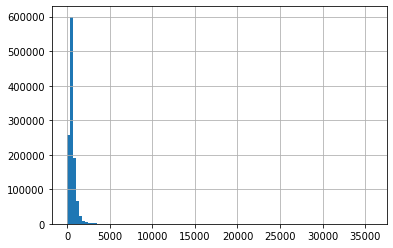

In [40]:
merge_df['면적당단가'].hist(bins=100)

<AxesSubplot:>

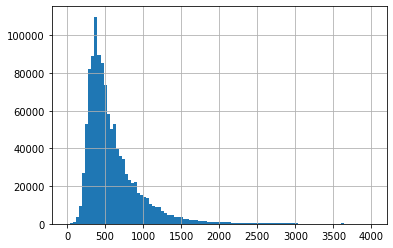

In [41]:
upper_limit_df = merge_df[merge_df['면적당단가'] < 4000]
upper_limit_df['면적당단가'].hist(bins=100)

<AxesSubplot:>

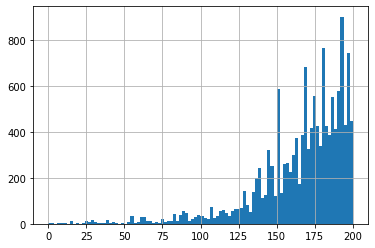

In [42]:
lower_limit_df = merge_df[merge_df['면적당단가'] < 200]
lower_limit_df['면적당단가'].hist(bins=100)

In [43]:
merge_df2 = merge_df[(merge_df['면적당단가'] >= 75)&(merge_df['면적당단가'] <= 4000)]
print(merge_df2.shape)

(1153645, 382)


<AxesSubplot:>

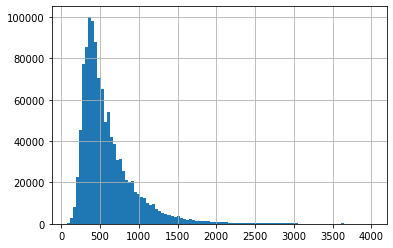

In [44]:
merge_df2['면적당단가'].hist(bins=100)

In [45]:
merge_df2.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,년,year_linear,month_sin,month_cos,건물연식,건물연식_카테고리화,xnorm,ynorm,x_2nd,y_2nd,xy,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가스공급시설,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고가도로,고도지구,고등학교,고속철도,고압선,공간시설미분류,공공공지,공공도서관,공공문화체육시설미분류,공공시설구역,공공시설용지,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공동구,공설화장시설,공용시설보호지구,공원,공원마을지구(공원집단시설지구),공원문화유산지구,공원자연보존지구,공원자연환경지구,공익용산지,공익임지,공장설립승인지역,공장설립제한지역,공항,공항소음피해예상지역,공항소음피해지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광역계획구역,광역복합환승센터,광장,교육환경보호구역,교차점광장,교통광장,교통운수시설미분류,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용기타용도지구,국토이용용도지구기타,군사기지_및_군사시설_보호구역,군사시설_보호구역,궤도,근린공원,근린광장,근린상업지역,기업형임대주택_공급촉진지구,기타공공공지시설,기타공공청사시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타도시방재시설,기타문화시설,기타방송통신시설,기타보건위생시설,기타사회복지시설,기타수도시설,기타시장시설,기타열공급설비,기타용도지역지구기타,기타용도지역지구미분류,기타용지,기타유통및공급시설,기타유통업무설비,기타자동차정류장,기타전기공급설비,기타주차장시설,기타철도시설,기타폐기물처리시설,기타하수도시설,기타학교시설,기타환경기초시설,노외주차장,녹지,농수산물공판장및농수산물종합유통센터,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시고속도로,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,등록문화재구역,리모델링지구,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화재보호구역기타,문화지구,미관지구,미관지구기타,박물관,방송통신시설,방수설비,방재지구,방화지구,배수시설,변전소(전원개발사업구역),변전시설,보건위생시설미분류,보전녹지지역,보전산지,보전임지,보조간선도로,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제1구역(전술),비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방시설,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업기술단지,산업시설구역,상대보호구역,상대정화구역,상수원보호구역,상수원보호기타,생산녹지지역,생태_경관보전지역,생태_경관완충보전구역,생태_경관핵심보전구역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,소하천예정지,수도공급시설,수변공원,수질오염방지시설,수평표면구역,시_도_생태_경관보전지역,시_도야생생물보호구역,시가지경관지구,시가지조성사업지역,시도지정문화재구역,시장,시장정비구역,시장정비구역기타,시험림구역,아파트지구,액화석유가스충전시설,야생생물보호구역,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,연구시설,열공급설비,온천공보호구역,온천원보호지구,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,운동장,원추표면구역,원형보존지,유류저장및송유설비,유수시설,유수지,유원지,유치원,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반광장,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차운전학원,자동차전용도로,자동차정류장,자연경관지구,자연공원용도지구기타,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,재해위험지구기타,재활용시설,저류시설,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제방,제한보호구역,제한보호구역(방공기지___1km),제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조례로정한지역,조망가로미관지구,조망가로특화경관지구,종합운동장,종합의료시설,주간선도로,주거용지,주거환경개선지구,주요시설광장,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심대광장,중심상업지역,중심지미관지구,중요시설물보존지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지정문화재구역,지하광장,지하도로,진입표면구역,집단취락지구,집산도로,철도,철도보호지구,청사,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,취수시설,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,토지구획정리사업지구기타,토지형질변경규제지역,통제보호구역,통제보호구역(민통선이남_300m),통제보호구역(방공기지_500m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리및재활용시설,폐기물처리시설,하수도,하수종말처리시설,하천,하천구역,하천미분류,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,홍수관리구역,화장장,환경정비구역,면적당단가
0,서울특별시 강남구 대치동 891-23,201404,22000,2004.0,아파트,43.39,대,일반상업지역,지정되지않음,상업기타,평지,부정형,소로각지,1,서울특별시 강남구 선릉로90길 56-0,강남구,대치동,2014,1.254795,1.000000,6.123234e-17,10.0,10년,7244.178842,-6450.462242,2.623906e+07,2.080423e+07,-4.672830e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,

In [46]:
cols_to_map = ['주택유형', '지목명', '용도지역명1', '용도지역명2', '토지이동상황', '지형높이', '지형형상', '도로접면', '구', '동', '건물연식_카테고리화']

In [47]:
for col in tqdm(cols_to_map):
    col_map = {}
    col_map_df = pd.DataFrame({'cat':merge_df2[col].unique(),'map':[i for i in range(len(merge_df2[col].unique()))]})
    for i in range(col_map_df.shape[0]):
        col_map[col_map_df['cat'][i]] = col_map_df['map'][i]
    merge_df2[col] = merge_df2[col].map(col_map)
    col_map_df.to_csv('./Training/training_data_ver_20/feature_maps/{}_map.csv'.format(col))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:02<00:00,  4.77it/s]


In [48]:
lp_cols = land_plans_df.columns.drop(['지번주소', '년'])
print(len(lp_cols))
lp_cols[:5]

353


Index(['(한강)오염행위_제한지역', '(한강)폐기물매립시설_설치제한지역', '4대문안', '가로구역별_최고높이_제한지역',
       '가스공급설비'],
      dtype='object')

In [49]:
cols_to_drop = []
for col in tqdm(merge_df2.columns):
    try:
        if merge_df2[col].std() == 0:
            cols_to_drop.append(col)
        else:
            pass
    except:
        pass

100%|████████████████████████████████████████████████████████████████████████████████| 382/382 [00:05<00:00, 67.69it/s]


In [50]:
len(cols_to_drop)

103

In [51]:
merge_df2 = merge_df2.drop(columns=cols_to_drop)

In [52]:
merge_df2.shape

(1153645, 279)

In [53]:
cat_cols = cols_to_map + lp_cols.tolist()
print(len(cat_cols))
cat_cols[:5]

364


['주택유형', '지목명', '용도지역명1', '용도지역명2', '토지이동상황']

In [54]:
for col in cols_to_drop:
    if col in cat_cols:
        cat_cols.remove(col)

In [55]:
print(len(cat_cols))
cat_cols[:5]

261


['주택유형', '지목명', '용도지역명1', '용도지역명2', '토지이동상황']

In [56]:
cat_cols_df = pd.DataFrame({'colname':cat_cols})
print(cat_cols_df.shape)
cat_cols_df.head()

(261, 1)


,colname
0,주택유형
1,지목명
2,용도지역명1
3,용도지역명2
4,토지이동상황


In [57]:
cat_cols_df.to_csv('./Training/training_data_ver_20/cat_cols.csv', index=False)

In [58]:
merge_df2.head()

,지번주소,계약년월,거래금액(만원),건축년도,주택유형,토지면적,지목명,용도지역명1,용도지역명2,토지이동상황,지형높이,지형형상,도로접면,건물유무,도로명주소,구,동,년,year_linear,month_sin,month_cos,건물연식,건물연식_카테고리화,xnorm,ynorm,x_2nd,y_2nd,xy,(한강)오염행위_제한지역,(한강)폐기물매립시설_설치제한지역,4대문안,가로구역별_최고높이_제한지역,가스공급설비,가축사육제한구역,개발제한구역,개발진흥지구,개발행위허가제한지역,건축선,건축용도지역기타,건축용도지역미분류,건축허가_착공제한지역,경관광장,경관녹지,경관지구,경관지구기타,고도지구,고속철도,공공공지,공공시설구역,공공주택지구,공공지원민간임대주택_공급촉진지구,공공청사,공용시설보호지구,공원,공원자연환경지구,공익용산지,공장설립승인지역,공장설립제한지역,공항소음피해예상지역,공항시설보호지구,과밀억제권역,광로1류(폭_70M_이상),광로2류(폭_50M_70M),광로3류(폭_40M_50M),광장,교육환경보호구역,교통광장,국가산업단지,국가지정문화재구역,국가하천,국립공원,국민임대주택단지예정지구,국지도로,국토이용용도지구기타,군사기지_및_군사시설_보호구역,근린공원,근린상업지역,기타공공공지시설,기타공원시설,기타교통시설,기타녹지시설,기타도로시설,기타도시공간시설,기타문화시설,기타자동차정류장,기타주차장시설,기타철도시설,기타폐기물처리시설,노외주차장,녹지,대공방어협조구역,대공방어협조구역(위탁고도_54_236m),대공방어협조구역(위탁고도_77_257m),대로1류(폭_35M_40M),대로2류(폭_30M_35M),대로3류(폭_25M_30M),대학,도로,도로구역,도서관,도시개발구역,도시개발구역기타,도시관리계획_입안중,도시기타용도지역지구기타,도시기타용도지역지구미분류,도시기타용도지역지구용도지역지구,도시자연공원,도시자연공원구역,도시지역,도시지역기타,도시철도,리모델링지구,묘지공원,문화공원,문화시설,문화재,문화재보존영향_검토대상구역,문화재보호구역,문화지구,미관지구,미관지구기타,박물관,방송통신시설,방수설비,방재지구,방화지구,보건위생시설미분류,보전산지,보전임지,보존지구,보행자전용도로,부설주차장,비오톱1등급,비행안전제2구역(전술),비행안전제2구역(지원),비행안전제3구역(전술),비행안전제3구역(지원),비행안전제4구역(전술),비행안전제4구역(지원),비행안전제5구역(전술),비행안전제5구역(지원),비행안전제6구역(전술),사고지,사방지,사업지역기타,사업지역미분류,사회복지시설,산업개발진흥지구,산업시설구역,상대보호구역,상대정화구역,상수원보호기타,생산녹지지역,소공원,소로1류(폭_10M_12M),소로2류(폭_8M_10M),소로3류(폭_8M_미만),소하천,소하천구역,수도공급시설,수평표면구역,시_도_생태_경관보전지역,시_도야생생물보호구역,시가지경관지구,시장,시장정비구역,아파트지구,어린이공원,여객자동차터미널,역사도심,역사문화미관지구,역사문화특화경관지구,역사문화환경보존지역,연결녹지,연구개발특구,열공급설비,온천공보호구역,완충녹지,용도구역기타,용도구역미분류,용도지구취락지구,원추표면구역,원형보존지,유수지,유원지,유통단지,유통상업지역,유통업무설비,일단의공업용지조성사업지역,일단의주택단지조성사업지역,일반도로,일반미관지구,일반산업단지,일반상업지역,일반주거지역,일반철도,임업용산지,자동차검사시설,자동차정류장,자연경관지구,자연녹지지역,자연재해위험지구,장애물제한표면구역,재개발구역,재개발구역기타,재정비촉진지구,재정비촉진지구기타,전기공급설비,전용주거지역,전이표면구역,전통사찰보존구역,절대보호구역,절대정화구역,정비구역,정비구역기타,정비예정구역,제1종일반주거지역,제1종전용주거지역,제1종지구단위계획구역,제2종일반주거지역,제2종전용주거지역,제3종_구역,제3종일반주거지역,제한보호구역,제한보호구역(방공기지___1km),제한보호구역(전술항공_5km),제한보호구역(후방지역_500m),조망가로미관지구,조망가로특화경관지구,종합의료시설,주간선도로,주거환경개선지구,주차장,주차장기타,주차환경개선지구,준공업지역,준보전산지,준주거지역,중로1류(폭_20M_25M),중로2류(폭_15M_20M),중로3류(폭_12M_15M),중심지미관지구,중요시설물보호지구,중요시설물보호지구(공용),중요시설물보호지구(공항),중점경관관리구역,중학교,지구단위계획구역,지역특화발전특구,지원시설구역,지하도로,진입표면구역,집단취락지구,철도,철도보호지구,청소년수련시설,체육공원,체육시설,초등학교,최고고도지구,침수위험지구,택지개발예정지구,택지개발예정지구기타,토지거래계약에관한허가구역,통제보호구역(민통선이남_300m),특수도로(보행자전용도로),특정개발진흥지구,특정용도제한지구,특화경관지구,폐기물처리시설,하수도,하천,하천구역,학교,학교시설보호지구,학교이적지,학교환경위생_정화구역,현상변경허가_대상구역,면적당단가
0,서울특별시 강남구 대치동 891-23,201404,22000,2004.0,0,43.39,0,0,0,0,0,0,0,1,서울특별시 강남구 선릉로90길 56-0,0,0,2014,1.254795,1.000000,6.123234e-17,10.0,0,7244.178842,-6450.462242,2.623906e+07,2.080423e+07,-4.672830e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,507.029269
1,서울특별시 강남구 대치동 891-23,201408,22500,2004.0,0,43.39,0,0,0,0,0,0,0,1,서울특별시 강남구 선릉로90길 56-0,0,0,2014,1.641096,-0.500000,-8.660254e-01,10.0,0,7244.178842,-6450.462242,2.623906e+07,2.080423e+07,-4.672830e+07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [59]:
%%time
merge_df2.to_csv('./Training/training_data_ver_20/training_data_ver_20.csv', index=False)

Wall time: 2min 22s
